In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime

import os
import sys
sys.path.append(os.path.abspath('..'))
from util import get_wikipedia_data
from brown import get_sentences_with_word2idx_limit_vocab, get_sentences_with_word2idx

from markov import get_bigram_probs

In [2]:
sentences, word2idx = get_sentences_with_word2idx_limit_vocab(2000)

In [8]:
print(sentences[0])
print([(k, v) for k, v in word2idx.items()][:10])

[13, 2000, 661, 2000, 1639, 74, 1850, 47, 2000, 16, 2000, 561, 1129, 1408, 1202, 26, 71, 483, 27, 21, 97, 2000, 224, 182, 15]
[('START', 0), ('END', 1), ('man', 2), ('paris', 3), ('britain', 4), ('england', 5), ('king', 6), ('woman', 7), ('rome', 8), ('london', 9)]


In [51]:
V = len(word2idx)
print("Vocab size:", V)

start_idx = word2idx['START']
end_idx = word2idx['END']

Vocab size: 2001


In [52]:
# a matrix where:
# row = last word
# col = current word
# value at [row, col] = p(current word | last word)
bigram_probs = get_bigram_probs(sentences,
                                V,
                                start_idx,
                                end_idx,
                                smoothing=0.1)

In [53]:
bigram_probs.shape

(2001, 2001)

In [58]:
def softmax(a):
    a = a - a.max()
    exp_a = np.exp(a)
    return exp_a / exp_a.sum(axis=1, keepdims=True)

# what is the loss if we set W = log(bigram_probs)?
W_bigram = np.log(bigram_probs)
bigram_losses = []
W = np.random.randn(V, V) / np.sqrt(V)
losses = []
epochs = 1
lr = 1e-1

In [61]:
t0 = datetime.now()
for epoch in range(epochs):
    # shuffle sentences at each epoch
    random.shuffle(sentences)

    j = 0  # keep track of iterations
    for sentence in sentences:
        # convert sentence into one-hot encoded inputs and targets
        sentence = [start_idx] + sentence + [end_idx]
        n = len(sentence)
        inputs = np.zeros((n - 1, V))
        targets = np.zeros((n - 1, V))
        inputs[np.arange(n - 1), sentence[:n - 1]] = 1
        targets[np.arange(n - 1), sentence[1:]] = 1

        # get output predictions
        predictions = softmax(inputs.dot(W))

        # do a gradient descent step
        W = W - lr * inputs.T.dot(predictions - targets)

        # keep track of the loss
        loss = -np.sum(targets * np.log(predictions)) / (n - 1)
        losses.append(loss)

        # keep track of the bigram loss
        # only do it for the first epoch to avoid redundancy
        if epoch == 0:
            bigram_predictions = softmax(inputs.dot(W_bigram))
            bigram_loss = -np.sum(targets * np.log(bigram_predictions)) / (n - 1)
            bigram_losses.append(bigram_loss)

        if j % 100 == 0:
            print("epoch:", epoch, "sentence: %s/%s" % (j, len(sentences)),
                  "loss:", loss)
        j += 1


epoch: 0 sentence: 0/57013 loss: 5.512732435206092
epoch: 0 sentence: 100/57013 loss: 5.730696071873969
epoch: 0 sentence: 200/57013 loss: 5.968245444113699
epoch: 0 sentence: 300/57013 loss: 5.614816690487054
epoch: 0 sentence: 400/57013 loss: 5.429267587877924
epoch: 0 sentence: 500/57013 loss: 6.966876391936343
epoch: 0 sentence: 600/57013 loss: 4.324839696788993
epoch: 0 sentence: 700/57013 loss: 6.523103331143446
epoch: 0 sentence: 800/57013 loss: 6.105911950656934
epoch: 0 sentence: 900/57013 loss: 2.7051769752001658
epoch: 0 sentence: 1000/57013 loss: 5.889532630202068
epoch: 0 sentence: 1100/57013 loss: 5.369535959419669
epoch: 0 sentence: 1200/57013 loss: 5.153267892713287
epoch: 0 sentence: 1300/57013 loss: 5.641749064241277
epoch: 0 sentence: 1400/57013 loss: 4.791815416589061
epoch: 0 sentence: 1500/57013 loss: 6.409046265106429
epoch: 0 sentence: 1600/57013 loss: 5.873698255737552


KeyboardInterrupt: 

Elapsed time training: 0:02:21.451505
avg_bigram_loss: 3.7812419764606955


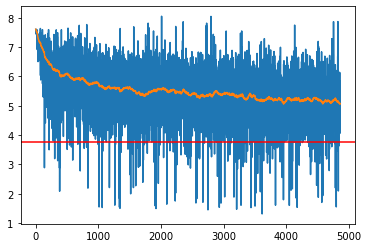

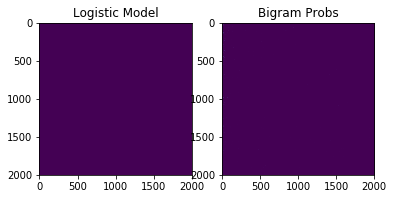

In [66]:
print("Elapsed time training:", datetime.now() - t0)
plt.plot(losses)

# plot a horizontal line for the bigram loss
avg_bigram_loss = np.mean(bigram_losses)
print("avg_bigram_loss:", avg_bigram_loss)
plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')


# plot smoothed losses to reduce variability
def smoothed_loss(x, decay=0.99):
    y = np.zeros(len(x))
    last = 0
    for t in range(len(x)):
        z = decay * last + (1 - decay) * x[t]
        y[t] = z / (1 - decay**(t + 1))
        last = z
    return y


plt.plot(smoothed_loss(losses))
plt.show()

# plot W and bigram probs side-by-side
# for the most common 200 words
plt.subplot(1, 2, 1)
plt.title("Logistic Model")
plt.imshow(softmax(W))
plt.subplot(1, 2, 2)
plt.title("Bigram Probs")
plt.imshow(bigram_probs)
plt.show()